# Content and Objectives

- Simulation for getting BER curves of misc. linear modulation schemes
- User-defined modulation symbols sent; ML detection (nearest neighbor) is applied as decision criterion

<b> Note: </b> Simulations are written with primary concern on readability and parallelism to theoretical results in the lecture. No optimization whatsoever has been conducted. If you want to speed up simulation time feel free...

# Importing

In [1]:
import numpy as np
from scipy import stats, special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

In [3]:
# plotting switches

plot_ber = 1
plot_ser = 1
plot_scatter = 1           # currently scatterplot is provided for max. SNR

# Parameters

In [4]:
# max. numbers of errors and/or symbols
# used as loop condition for the simulation
max_errors = 100
max_syms = int( 1e4 )

EbN0_db_min = 0
EbN0_db_max = 22
EbN0_db_step = 4

# choose mod. scheme

# NOTE: Don't be too generous since graphical representation may suffer 
# if many different schemes are to be plotted

# NOTE 2: Please write mod scheme as: 'ORDER-SCHEME' with ORDER being a power of 2

#mod = [ '2-PSK' ]
#mod = [ '4-ASK', '4-PSK', '4-QAM']
mod = [ '16-ASK', '16-PSK', '16-QAM']
#mod = [ '16-ASK', '16-PSK', '16-QAM', '64-ASK', '64-PSK', '64-QAM']

# initialize Eb/N0 array
EbN0_db_range = np.arange( EbN0_db_min, EbN0_db_max, EbN0_db_step )
EbN0_range = 10**( EbN0_db_range / 10 )
    

# Some Helpers

+ Function for finding constellation incl. normalizing average energy
+ Function for modulating by simple look-up
+ Function for ML demod
+ Function for getting theoretical SERs

In [5]:
######## functions for finding constellation, modulating and demodulating

def find_constellation(M, mod_scheme):
    """
    Determines the constellation diagram based in M and the modulation scheme,
    the power of the constellation being normalized to one
    
    IN: M, mod_scheme
    OUT: constellation (as list)
    """


    if mod_scheme=='ASK':
        
        constellation = np.zeros(M)
        
        for m in range(0, M):
            x = 2 * m - M + 1
            constellation[ m ] = x

    elif mod_scheme=='PSK':
        
        constellation = np.zeros( M, dtype=complex )
        
        for m in range( 0, M ):
            if M==2:
                x = complex( np.cos( 2*np.pi * m / M ), np.sin( 2*np.pi * m / M ))
            else:
                x = complex( np.cos( 2*np.pi* m / M ), np.sin( 2*np.pi * m / M ) )

            constellation[ m ] = x

    elif mod_scheme=='QAM':
        
        constellation = np.zeros(M, dtype=complex)

        # assign QAM modulation for M being a power of 2 first
        if int( np.sqrt( M ) ) == np.sqrt( M ):
            
            # Gray encoded symbols
            k = int( np.log2( M ) )  
            for m in range(0,M):   
                
                # int to binary string
                b_bin = np.binary_repr( m, width=k)
                    
                # map binary to +-1
                b = [ (-1)**( int(x) ) for x in b_bin]
            
                d = np.sqrt( M ) / 2
                dx = 1
                dy = 1
                s = 0 + 1j*0
                
                # determine signal point
                for n in np.arange(0, int(k/2)):
                    dx *= b[ 2*n ]
                    dy *= b[ 2*n + 1 ]
                    
                    s += d * ( dx + 1j * dy )
                    
                    d = d/2;       
                    
                constellation[ m ] = s

        # deduce QAM modulation for M = 2^k/2 out of "parent" 2^k
        elif int(np.sqrt(2*M)) == np.sqrt(2*M):
            
            # determine constellation for 2*M
            const_temp = find_constellation( 2*M, 'QAM' )
            
            # choose those signal points with negative imaginary part
            constellation = [c for c in const_temp if np.imag(c)<0]
                    
            # shift constellation such that average is in the origin
            constellation -= np.average( constellation )           
       
    else:
        print('No feasible input')
        sys.exit()
    
    # normalizing constellation to having power equal to 1    
    constellation /= np.sqrt( np.linalg.norm( constellation )**2 / M )
    
    return list(constellation)
    

In [6]:
def modulate(d, constellation):
    """
    Modulate by assigning the corresponding constellation point
    
    """
    
    if np.size(d) == 1:
        x = constellation[ d ]
        return x 
    
    else:
        x = [constellation[ s ] for s in d]
        return x

In [7]:
def demod_ML_awgn(y, constellation):
    """
    Pointwise detection with the ML method, meaning least distance in the complex plane

    IN: y, constellation
    OUT: x_est (hard decision)
    """

    if np.size( y ) == 1:   # apply decision rule 
        
        dist_min = float('Inf')
        x_dec = 0

        for x in constellation:
            dist = np.abs(y-x)**2

            if dist < dist_min:
                dist_min = dist
                x_dec = x

        return constellation.index(x_dec)

    else:  # apply decision rule to every element of the vector
        
        demod = np.zeros(len(y))

        for k in np.arange(0, len(y)):
            demod[k] = demod_ML_awgn( y[ k ] )

        return demod

In [8]:
def ser_awgn_theory( EbN0_db_range, M, mod_scheme):
    """
    Provides theoretical curves (resp. approximations) for the SERs

    IN: EbN0_db_range, M, mod_scheme
    OUT: ber_theo
    """
    
    ser_theo = []
    
    EbN0 = 10**( EbN0_db_range / 10.0 )
    
    if mod_scheme == 'ASK':
        
        arg_Q = np.sqrt( 6 * np.log2(M) * EbN0 / ( M**2-1 ) )
        ser_theo = 2. * (M-1) / M * ( 1 - special.ndtr( arg_Q ) )
            
    elif mod_scheme=='PSK':
        
        arg_Q = np.sqrt( 2. * np.log2(M) * EbN0 ) * np.sin( np.pi / M )        
        ser_theo = 2. * ( 1 - special.ndtr( arg_Q ) )      
            
    elif mod_scheme=='QAM':
 
        arg_Q = np.sqrt( 3. * np.log2(M) * EbN0 / (M-1) )      
        ser_theo = 1 - ( 1 - 2. * ( np.sqrt(M) - 1 ) / np.sqrt(M) * ( 1 - special.ndtr( arg_Q ) ) )**2 


    else:
        print('No feasible input')
        sys.exit()
        
    return ser_theo

# Simulation

In [9]:
# initialize BER  and SER array with |mod| rows and |EbN0| columns
ber = np.zeros( (len(mod), len(EbN0_db_range)) )
ber_theo = np.zeros( (len(mod), len(EbN0_db_range)) )

ser = np.zeros( (len(mod), len(EbN0_db_range)) )
ser_theo = np.zeros( (len(mod), len(EbN0_db_range)) )    

# array for collecting Rx out values in order to show scatter plott
y_observed = np.zeros( (len(mod), max_syms), dtype=complex )

for ind_m, val_m in enumerate( mod ):

    # find modulation type and constellation points
    M = int( ( val_m.partition('-'))[0] )
    mod_scheme = ( val_m.partition('-'))[2]  
    
    constellation = find_constellation(M, mod_scheme)

    # loop for snr
    for ind_ebn0, ebn0_db in enumerate( EbN0_db_range ):

        # initialize for counting errors, symbols and powers as well as Es/N0
        num_errors = 0
        num_syms = 0

        Px = 0
        Pn = 0

        esn0_db = ebn0_db + 10 * np.log10( np.log2( M ) )


        # loop for errors
        while (num_errors < max_errors and num_syms < max_syms):

            # generate random symbol (int) and modulate
            d = np.random.randint( 0, M)
            s = complex( modulate(d, constellation) )

            # add noise
            sigma2 = 10**( - esn0_db / 10)
            noise = np.sqrt( sigma2 / 2 ) * ( np.random.randn() + 1j * np.random.randn() ) 

            y = s + noise

            # collect output points for scatter plot
            if ebn0_db == max(EbN0_db_range) and plot_scatter:
                y_observed[ ind_m, num_syms ] = y

            Px += abs(s)**2
            Pn += abs(noise)**2

            # demod and look for error
            d_est = demod_ML_awgn( y, constellation)

            if np.abs(d_est-d) > 5*np.spacing(1):
                num_errors += 1

            num_syms += 1

        # find ber and ser
        ber[ ind_m, ind_ebn0 ] = num_errors / ( num_syms * 1.0 * np.log2(M) )
        ser[ ind_m, ind_ebn0 ] = num_errors / ( num_syms * 1.0 )            

        snr_meas = 10*np.log10(Px/Pn)    

        print('Modulation: ', val_m, '; \tEs/N0 planned= %3.2f' %esn0_db, 'dB, Es/N0 real= %3.2f' %snr_meas , 'dB')

    print (' ' )


    # theoretical values
    ser_theo[ ind_m, :] = ser_awgn_theory( EbN0_db_range, M, mod_scheme)  
    ber_theo[ ind_m, :] = ser_theo[ ind_m, :] / np.log2(M)

Modulation:  16-ASK ; 	Es/N0 planned= 6.02 dB, Es/N0 real= 5.57 dB
Modulation:  16-ASK ; 	Es/N0 planned= 10.02 dB, Es/N0 real= 10.30 dB
Modulation:  16-ASK ; 	Es/N0 planned= 14.02 dB, Es/N0 real= 13.83 dB
Modulation:  16-ASK ; 	Es/N0 planned= 18.02 dB, Es/N0 real= 18.08 dB
Modulation:  16-ASK ; 	Es/N0 planned= 22.02 dB, Es/N0 real= 21.69 dB
Modulation:  16-ASK ; 	Es/N0 planned= 26.02 dB, Es/N0 real= 26.05 dB
 
Modulation:  16-PSK ; 	Es/N0 planned= 6.02 dB, Es/N0 real= 5.97 dB
Modulation:  16-PSK ; 	Es/N0 planned= 10.02 dB, Es/N0 real= 10.10 dB
Modulation:  16-PSK ; 	Es/N0 planned= 14.02 dB, Es/N0 real= 14.13 dB
Modulation:  16-PSK ; 	Es/N0 planned= 18.02 dB, Es/N0 real= 18.14 dB
Modulation:  16-PSK ; 	Es/N0 planned= 22.02 dB, Es/N0 real= 22.04 dB
Modulation:  16-PSK ; 	Es/N0 planned= 26.02 dB, Es/N0 real= 25.97 dB
 
Modulation:  16-QAM ; 	Es/N0 planned= 6.02 dB, Es/N0 real= 6.48 dB
Modulation:  16-QAM ; 	Es/N0 planned= 10.02 dB, Es/N0 real= 9.79 dB
Modulation:  16-QAM ; 	Es/N0 planned=

# Plotting

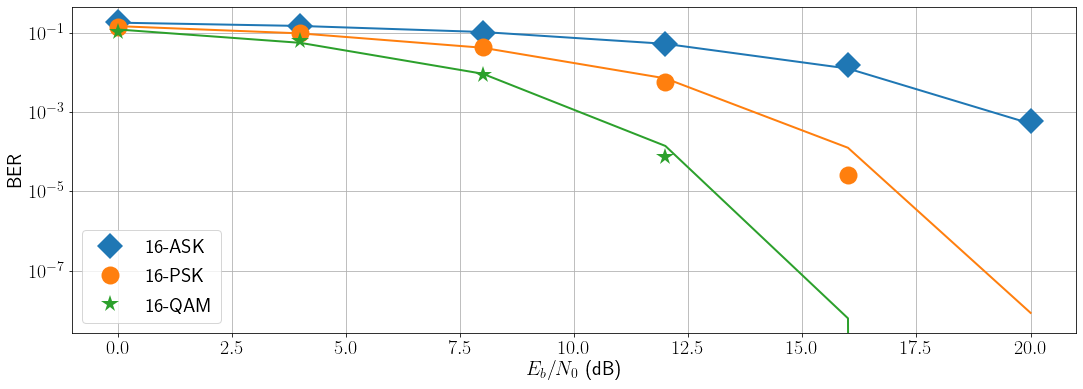

In [10]:
markers = [ 'D', 'o', '*', 's', 'v', 'p' ]
mark_ind = 0    

if plot_ber:
    plt.figure()
    for ind_m, m in enumerate( mod ):
        
        ax_sim = plt.plot(EbN0_db_range, ber[ ind_m, :], marker = markers[ mark_ind % len( markers) ] , mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label = str(m) )            

        color_sim = ax_sim[0].get_color()     
        mark_ind += 1

        plt.plot(EbN0_db_range, ber_theo[ ind_m, :], linewidth = 2.0, color = color_sim )  

    plt.yscale('log')
    plt.grid(True)
    plt.legend(loc='lower left') 

    plt.xlabel('$E_b/N_0$ (dB)')
    plt.ylabel('BER')

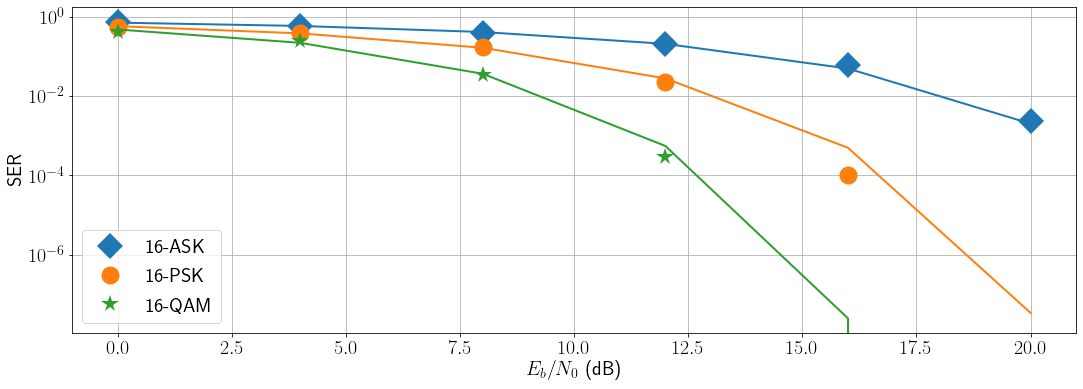

In [11]:
if plot_ser:
        
    # curves for theory and simulation
    plt.figure()
    for ind_m, m in enumerate( mod ):
        #plot(EbN0_db_range, ser[ mod.index(m), :], marker_type[ mod.index(m)], color=line_color[ mod.index(m)], label=m+" simulation")            
        #plot(EbN0_db_range, ser_theo[mod.index(m), :], linestyle = line_type[ mod.index(m)] %3, color=line_color[ mod.index(m)], label=m+" theory")

        #ax_sim = plt.plot(EbN0_db_range, ser[ ind_m, :], '-', marker = markers[ mark_ind % 3] , mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label = str(m) + ' sim.')            
        ax_sim = plt.plot(EbN0_db_range, ser[ ind_m, :], '-', marker = markers[ mark_ind % 3] , mew=4, ms=18, markeredgecolor = 'none', linestyle='None', label = str(m) )            

        color_sim = ax_sim[0].get_color()     
        mark_ind += 1

        #plt.plot(EbN0_db_range, ser_theo[ ind_m, :], linewidth = 2.0, color = color_sim, label = str(m) + ' theo.')  
        plt.plot(EbN0_db_range, ser_theo[ ind_m, :], linewidth = 2.0, color = color_sim )  

    plt.yscale('log')
    plt.grid(True)
    plt.legend(loc='lower left') 

    plt.xlabel('$E_b/N_0$ (dB)')
    plt.ylabel('SER')

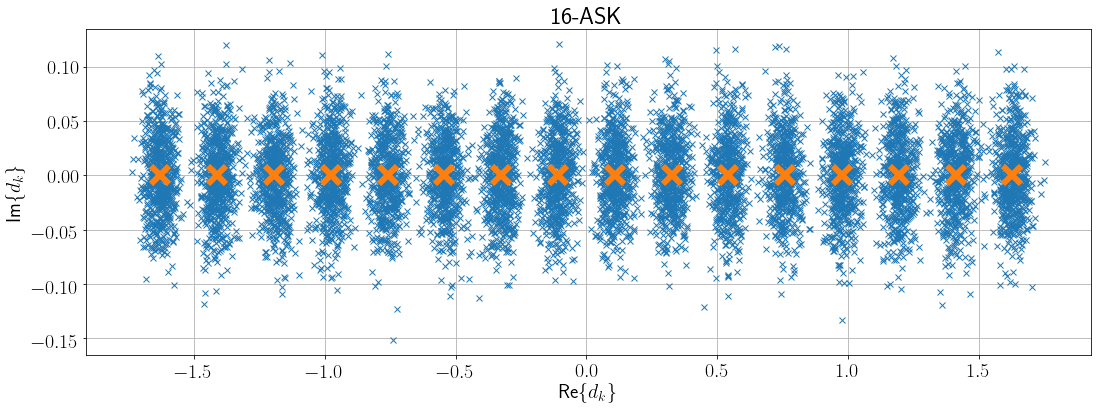

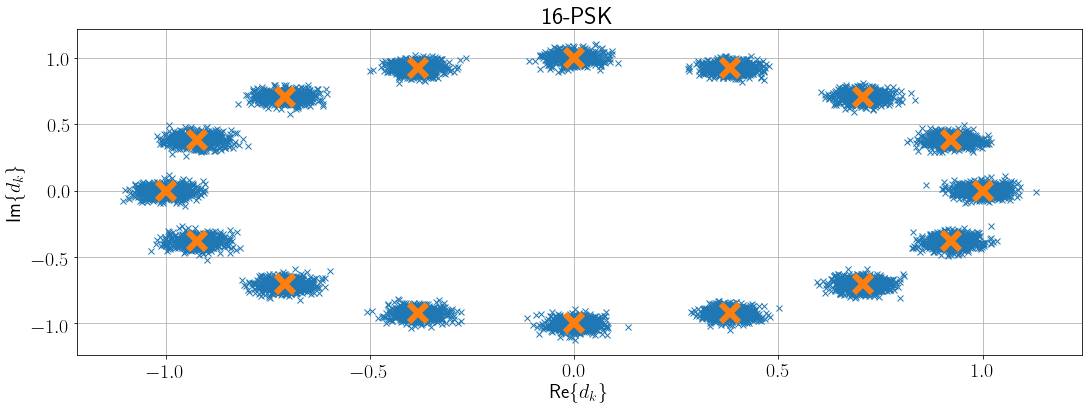

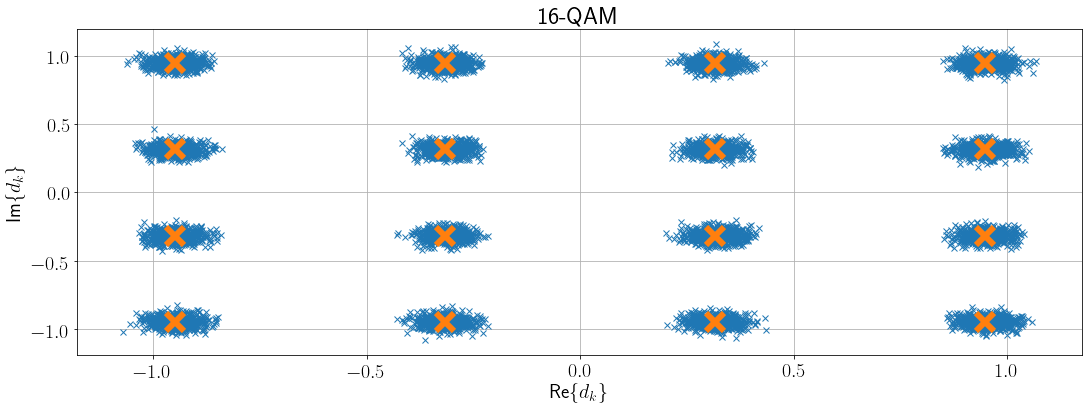

In [12]:
if plot_scatter:
    for m in mod:
        plt.figure()

        plt.title(m)

        M = int( ( m.partition('-') )[0] )
        mod_scheme = ( m.partition('-') )[2]  
        constellation = find_constellation( M, mod_scheme )    

        re=[]
        im=[]

        for c in constellation:
            re.append(c.real)
            im.append(c.imag)

        re_y=[]
        im_y=[]    
        for y in y_observed[ mod.index(m) , :]:
            re_y.append(y.real)
            im_y.append(y.imag)           

        plt.plot( re_y, im_y, 'x')
        plt.plot( re, im, 'x', markersize=18, mew=6)

        plt.grid(True)
        plt.xlabel('Re\{$d_k$\}')
        plt.ylabel('Im\{$d_k$\}') 